In [4]:
import glob
import logging
from collections import defaultdict
from pathlib import Path
from typing import Dict, Optional, Tuple, List, Any

import numpy as np
import torch
import torch.nn.functional as F
from scipy.stats import pearsonr
from tqdm import tqdm
from vit_prisma.models.base_vit import HookedSAEViT
from vit_prisma.sae import SparseAutoencoder
import torchvision # Required for the dataset with paths

# --- Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Helper Functions for New Metrics ---

def _calculate_gini(x: torch.Tensor) -> float:
    """Calculates the Gini coefficient of a 1D tensor."""
    if x.sum() == 0 or x.numel() < 2:
        return 0.0
    # Ensure all values are non-negative for Gini calculation
    x = x.abs()
    # Sort in ascending order
    x_sorted = torch.sort(x)[0]
    n = x.numel()
    # Cumulative sum
    cumx = torch.cumsum(x_sorted, dim=0)
    # Gini formula
    return ((n + 1 - 2 * torch.sum(cumx) / cumx[-1]) / n).item()

def _calculate_dice(pred: torch.Tensor, target: torch.Tensor, threshold: float = 0.1) -> float:
    """Calculates the Dice coefficient for two 1D tensors after thresholding."""
    pred_mask = (pred > threshold).float()
    target_mask = (target > threshold).float()
    
    intersection = (pred_mask * target_mask).sum()
    return ((2. * intersection) / (pred_mask.sum() + target_mask.sum() + 1e-8)).item()


# --- Main Dictionary Building Function ---

def build_attribution_aligned_feature_dictionary(
    model: HookedSAEViT,
    sae: SparseAutoencoder,
    dataloader: torch.utils.data.DataLoader,
    attribution_dir: str,
    n_samples: int = 1000,
    layer_idx: int = 9,
    patch_size: int = 16, # <-- Added patch_size parameter
    min_occurrences: int = 5,
    save_path: Optional[str] = None
) -> Dict[str, Any]:
    """
    Builds a dictionary of features based on their alignment with baseline attribution maps,
    now with correct downsampling of high-resolution attribution maps.

    Args:
        model: Hooked SAE Vision Transformer.
        sae: Sparse Autoencoder.
        dataloader: A DataLoader that yields (image, label, path).
        attribution_dir: Directory where pre-computed high-res attribution .npy files are stored.
        n_samples: Maximum number of samples to process.
        layer_idx: Transformer layer to analyze.
        patch_size: The size of a single patch (e.g., 16 for ViT-B/16).
        min_occurrences: Minimum times a feature must appear to be considered reliable.
        save_path: Optional path to save the final dictionary.

    Returns:
        A dictionary containing features and their alignment/localization metrics.
    """
    device = next(model.parameters()).device
    feature_occurrences = defaultdict(list)
    samples_processed = 0

    resid_hook_name = f"blocks.{layer_idx}.hook_resid_post"
    pbar = tqdm(dataloader, total=min(n_samples, len(dataloader)), desc="Analyzing feature alignment")
    reliable_features = {}

    for imgs, labels, paths in pbar:
        if samples_processed >= n_samples:
            break

        # Process one image at a time
        image, label, path = imgs[0:1].to(device), labels[0].item(), paths[0]
        
        # --- 1. Get SAE feature activations ---
        with torch.no_grad():
            _, cache = model.run_with_cache(image, names_filter=[resid_hook_name])
            resid = cache[resid_hook_name]
            _, codes = sae.encode(resid)
        
        # Patch tokens only: (196, n_features)
        feature_activations = codes[0, 1:]

        # --- 2. Load and DOWNSAMPLE the corresponding attribution map ---
        try:
            # More robustly find the attribution file
            img_filename_stem = Path(path).stem
            # Example: dev_192e44d5-8f85-4841-8f5d-59d4c728564e_ileum_aug0
            # We want to match `dev_192e44d5-8f85-4841-8f5d-59d4c728564e_*_aug0_attribution.npy`
            parts = img_filename_stem.split('_')
            prefix = 'train' # e.g., 'dev'
            uuid = parts[0]
            aug_part = parts[1] # e.g., 'aug0'
            
            # Construct a glob pattern that is less sensitive to the class name in the middle
            attr_pattern = str(Path(attribution_dir) / f"{prefix}_{uuid}_*_{aug_part}_attribution.npy")
            attr_files = glob.glob(attr_pattern)
            
            if not attr_files:
                logging.warning(f"Attribution not found for pattern {attr_pattern}, skipping.")
                continue
            
            attr_path = attr_files[0]
            if len(attr_files) > 1:
                logging.warning(f"Multiple attributions for {img_filename_stem}, using first: {attr_path}")

            # *** THE FIX: Load and correctly downsample the map ***
            attr_map_high_res = np.load(attr_path) # Expected shape (H, W), e.g., (224, 224)
            
            # Ensure it's a 2D map before processing
            if attr_map_high_res.ndim != 2:
                logging.warning(f"Unexpected attribution map shape {attr_map_high_res.shape} for {attr_path}, skipping.")
                continue

            # Reshape for pooling: (N, C, H, W) -> (1, 1, 224, 224)
            attr_tensor_high_res = torch.from_numpy(attr_map_high_res).unsqueeze(0).unsqueeze(0).float().to(device)

            # Use average pooling to downsample to patch resolution
            attr_tensor_patch_level_2d = F.avg_pool2d(
                attr_tensor_high_res,
                kernel_size=patch_size,
                stride=patch_size
            )
            
            # Flatten to a vector for correlation: (1, 1, 14, 14) -> (196,)
            attr_vec = attr_tensor_patch_level_2d.flatten()
            
            if attr_vec.shape[0] != feature_activations.shape[0]:
                 logging.warning(
                    f"Attribution map shape mismatch after downsampling for {img_filename_stem} "
                    f"({attr_vec.shape[0]}) vs patch count "
                    f"({feature_activations.shape[0]}). Check patch_size. Skipping."
                )
                 continue
            
            # Normalize for stable dot products and correlation
            attr_vec = (attr_vec - attr_vec.mean()) / (attr_vec.std() + 1e-8)

        except Exception as e:
            logging.warning(f"Error loading or processing attribution for {img_filename_stem}: {e}, skipping.")
            continue

        # --- 3. Compute alignment metrics for active features ---
        active_feature_indices = (feature_activations.abs().sum(dim=0) > 1e-6).nonzero(as_tuple=True)[0]
        
        for feat_idx in active_feature_indices:
            feat_vec = feature_activations[:, feat_idx]
            
            if feat_vec.std() < 1e-6: continue
            
            # Pearson Correlation (PFAC)
            # Both vectors are now guaranteed to be on the same device and have the correct length
            corr, _ = pearsonr(attr_vec.cpu().numpy(), feat_vec.cpu().numpy())
            if np.isnan(corr): corr = 0.0

            # Attribution-Weighted Activation (AWA)
            awa_score = torch.dot(attr_vec, feat_vec).item()
            
            # Activation Concentration (Gini)
            gini_score = _calculate_gini(feat_vec)

            # Overlap Score (Dice)
            dice_score = _calculate_dice(feat_vec, attr_vec)

            feature_occurrences[feat_idx.item()].append({
                'pfac_corr': corr,
                'awa_score': awa_score,
                'gini_score': gini_score,
                'dice_score': dice_score,
                'class': label
            })

        samples_processed += 1
        pbar.set_postfix({"Processed": samples_processed, "Reliable Features": len(reliable_features)})
    
    # --- 4. Aggregate results and build final dictionary ---
    # (The rest of the function for aggregation remains the same, as it's already correct)
    for feat_id, occurrences in feature_occurrences.items():
        if len(occurrences) < min_occurrences:
            continue
        pfac_corrs = [o['pfac_corr'] for o in occurrences]
        awa_scores = [o['awa_score'] for o in occurrences]
        gini_scores = [o['gini_score'] for o in occurrences]
        dice_scores = [o['dice_score'] for o in occurrences]
        classes = [o['class'] for o in occurrences]
        mean_pfac = np.mean(pfac_corrs)
        cv_pfac = np.std(pfac_corrs) / (abs(mean_pfac) + 1e-6)
        consistency_score = mean_pfac * (1 - cv_pfac) * np.log1p(len(occurrences))
        reliable_features[feat_id] = {
            'mean_pfac_corr': mean_pfac, 'std_pfac_corr': np.std(pfac_corrs), 'cv_pfac_corr': cv_pfac,
            'mean_awa_score': np.mean(awa_scores), 'std_awa_score': np.std(awa_scores),
            'mean_gini_score': np.mean(gini_scores), 'mean_dice_score': np.mean(dice_scores),
            'consistency_score': consistency_score, 'occurrences': len(occurrences),
            'classes_activated': list(set(classes)),
            'raw_metrics': {'pfac_corrs': pfac_corrs, 'awa_scores': awa_scores, 'gini_scores': gini_scores, 'dice_scores': dice_scores, 'classes': classes}
        }
    
    # --- 5. Finalize and Save Dictionary ---
    if reliable_features:
        sorted_features = sorted(reliable_features.items(), key=lambda item: item[1]['consistency_score'], reverse=True)
        final_dict = {
            'feature_stats': dict(sorted_features),
            'metadata': { 'layer_idx': layer_idx, 'patch_size': patch_size, 'n_samples_processed': samples_processed, 'min_occurrences': min_occurrences, 'attribution_dir': attribution_dir },
            'metric_definitions': { 'pfac_corr': "Pearson Correlation between feature activations and downsampled attribution map.", 'awa_score': "Attribution-Weighted Activation (dot product).", 'gini_score': "Spatial concentration of feature activations.", 'dice_score': "Spatial overlap (Dice) of thresholded maps.", 'consistency_score': "Overall score rewarding high, stable alignment and frequency." }
        }
    else:
        final_dict = {'feature_stats': {}, 'metadata': {}}
        logging.warning("No reliable features found meeting the criteria.")

    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        torch.save(final_dict, save_path)
        logging.info(f"Attribution alignment dictionary saved to {save_path}")

    return final_dict


In [5]:
import glob
import logging
from collections import defaultdict
from pathlib import Path
from typing import Dict, Optional, Tuple, List, Any

import numpy as np
import torch
import torch.nn.functional as F
from scipy.stats import pearsonr
from tqdm import tqdm
from vit_prisma.models.base_vit import HookedSAEViT
from vit_prisma.sae import SparseAutoencoder
import torchvision # Required for the dataset with paths

# --- Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Vectorized Helper Functions ---

def batch_gini(features: torch.Tensor) -> torch.Tensor:
    """
    Calculates Gini coefficients for multiple features at once.
    Args:
        features: (n_patches, n_features) tensor
    Returns:
        (n_features,) tensor of Gini coefficients
    """
    # Handle edge cases
    if features.shape[1] == 0:
        return torch.tensor([])
    
    # Sort each feature column
    sorted_features, _ = torch.sort(features.abs(), dim=0)
    n = features.shape[0]
    cumsum = torch.cumsum(sorted_features, dim=0)
    
    # Avoid division by zero
    cumsum_last = cumsum[-1].clamp(min=1e-8)
    
    return (n + 1 - 2 * cumsum.sum(dim=0) / cumsum_last) / n

def batch_dice(features: torch.Tensor, target: torch.Tensor, threshold: float = 0.1) -> torch.Tensor:
    """
    Calculates Dice coefficients for multiple features against a target.
    Args:
        features: (n_patches, n_features) tensor
        target: (n_patches,) tensor
        threshold: threshold for binarization
    Returns:
        (n_features,) tensor of Dice coefficients
    """
    feat_masks = (features > threshold).float()
    target_mask = (target > threshold).float().unsqueeze(1)
    
    intersections = (feat_masks * target_mask).sum(dim=0)
    unions = feat_masks.sum(dim=0) + target_mask.sum()
    
    return (2 * intersections / (unions + 1e-8))

# --- Main Dictionary Building Function ---

def build_attribution_aligned_feature_dictionary(
    model: HookedSAEViT,
    sae: SparseAutoencoder,
    dataloader: torch.utils.data.DataLoader,
    attribution_dir: str,
    n_samples: int = 1000,
    layer_idx: int = 9,
    patch_size: int = 16,
    min_occurrences: int = 5,
    save_path: Optional[str] = None
) -> Dict[str, Any]:
    """
    Builds a dictionary of features based on their alignment with baseline attribution maps,
    using vectorized operations for efficiency.

    Args:
        model: Hooked SAE Vision Transformer.
        sae: Sparse Autoencoder.
        dataloader: A DataLoader that yields (image, label, path).
        attribution_dir: Directory where pre-computed high-res attribution .npy files are stored.
        n_samples: Maximum number of samples to process.
        layer_idx: Transformer layer to analyze.
        patch_size: The size of a single patch (e.g., 16 for ViT-B/16).
        min_occurrences: Minimum times a feature must appear to be considered reliable.
        save_path: Optional path to save the final dictionary.

    Returns:
        A dictionary containing features and their alignment/localization metrics.
    """
    device = next(model.parameters()).device
    feature_occurrences = defaultdict(list)
    samples_processed = 0

    resid_hook_name = f"blocks.{layer_idx}.hook_resid_post"
    pbar = tqdm(dataloader, total=min(n_samples, len(dataloader)), desc="Analyzing feature alignment")
    reliable_features = {}

    for imgs, labels, paths in pbar:
        if samples_processed >= n_samples:
            break

        # Process one image at a time
        image, label, path = imgs[0:1].to(device), labels[0].item(), paths[0]
        
        # --- 1. Get SAE feature activations ---
        with torch.no_grad():
            _, cache = model.run_with_cache(image, names_filter=[resid_hook_name])
            resid = cache[resid_hook_name]
            _, codes = sae.encode(resid)
        
        # Patch tokens only: (196, n_features)
        feature_activations = codes[0, 1:]

        # --- 2. Load and DOWNSAMPLE the corresponding attribution map ---
        try:
            # More robustly find the attribution file
            img_filename_stem = Path(path).stem
            parts = img_filename_stem.split('_')
            prefix = 'train'
            uuid = parts[0]
            aug_part = parts[1]
            
            # Construct a glob pattern
            attr_pattern = str(Path(attribution_dir) / f"{prefix}_{uuid}_*_{aug_part}_attribution.npy")
            attr_files = glob.glob(attr_pattern)
            
            if not attr_files:
                logging.warning(f"Attribution not found for pattern {attr_pattern}, skipping.")
                continue
            
            attr_path = attr_files[0]
            if len(attr_files) > 1:
                logging.warning(f"Multiple attributions for {img_filename_stem}, using first: {attr_path}")

            # Load and correctly downsample the map
            attr_map_high_res = np.load(attr_path)
            
            # Ensure it's a 2D map before processing
            if attr_map_high_res.ndim != 2:
                logging.warning(f"Unexpected attribution map shape {attr_map_high_res.shape} for {attr_path}, skipping.")
                continue

            # Reshape for pooling: (N, C, H, W) -> (1, 1, 224, 224)
            attr_tensor_high_res = torch.from_numpy(attr_map_high_res).unsqueeze(0).unsqueeze(0).float().to(device)

            # Use average pooling to downsample to patch resolution
            attr_tensor_patch_level_2d = F.avg_pool2d(
                attr_tensor_high_res,
                kernel_size=patch_size,
                stride=patch_size
            )
            
            # Flatten to a vector for correlation: (1, 1, 14, 14) -> (196,)
            attr_vec = attr_tensor_patch_level_2d.flatten()
            
            if attr_vec.shape[0] != feature_activations.shape[0]:
                logging.warning(
                    f"Attribution map shape mismatch after downsampling for {img_filename_stem} "
                    f"({attr_vec.shape[0]}) vs patch count "
                    f"({feature_activations.shape[0]}). Check patch_size. Skipping."
                )
                continue
            
            # Normalize for stable dot products and correlation
            attr_vec = (attr_vec - attr_vec.mean()) / (attr_vec.std() + 1e-8)

        except Exception as e:
            logging.warning(f"Error loading or processing attribution for {img_filename_stem}: {e}, skipping.")
            continue

        # --- 3. VECTORIZED computation of alignment metrics for active features ---
        active_feature_indices = (feature_activations.abs().sum(dim=0) > 1e-6).nonzero(as_tuple=True)[0]
        
        if len(active_feature_indices) == 0:
            continue
            
        # Get all active features at once
        active_features = feature_activations[:, active_feature_indices]  # (196, n_active)
        
        # 1. Vectorized correlations
        # Normalize features
        feat_means = active_features.mean(dim=0, keepdim=True)
        feat_stds = active_features.std(dim=0, keepdim=True)
        # Handle features with zero std
        valid_std_mask = feat_stds.squeeze() > 1e-6
        
        if valid_std_mask.sum() == 0:
            continue
            
        # Filter to only valid features
        valid_indices = active_feature_indices[valid_std_mask]
        valid_features = active_features[:, valid_std_mask]
        valid_feat_means = feat_means[:, valid_std_mask]
        valid_feat_stds = feat_stds[:, valid_std_mask]
        
        # Normalize
        active_features_norm = (valid_features - valid_feat_means) / (valid_feat_stds + 1e-8)
        
        # Compute correlations using matrix multiplication
        n_patches = len(attr_vec)
        correlations = torch.matmul(attr_vec.unsqueeze(0), active_features_norm).squeeze() / (n_patches - 1)
        
        # 2. Vectorized AWA scores
        awa_scores = torch.matmul(attr_vec.unsqueeze(0), valid_features).squeeze()
        
        # 3. Vectorized Gini coefficients
        gini_scores = batch_gini(valid_features)
        
        # 4. Vectorized Dice scores
        dice_scores = batch_dice(valid_features, attr_vec)
        
        # Store results
        for i, feat_idx in enumerate(valid_indices):
            feature_occurrences[feat_idx.item()].append({
                'pfac_corr': correlations[i].item(),
                'awa_score': awa_scores[i].item(),
                'gini_score': gini_scores[i].item(),
                'dice_score': dice_scores[i].item(),
                'class': label
            })

        samples_processed += 1
        pbar.set_postfix({"Processed": samples_processed, "Active Features": len(valid_indices)})
    
    # --- 4. Aggregate results and build final dictionary ---
    for feat_id, occurrences in feature_occurrences.items():
        if len(occurrences) < min_occurrences:
            continue
            
        pfac_corrs = [o['pfac_corr'] for o in occurrences]
        awa_scores = [o['awa_score'] for o in occurrences]
        gini_scores = [o['gini_score'] for o in occurrences]
        dice_scores = [o['dice_score'] for o in occurrences]
        classes = [o['class'] for o in occurrences]
        
        mean_pfac = np.mean(pfac_corrs)
        cv_pfac = np.std(pfac_corrs) / (abs(mean_pfac) + 1e-6)
        consistency_score = mean_pfac * (1 - cv_pfac) * np.log1p(len(occurrences))
        
        reliable_features[feat_id] = {
            'mean_pfac_corr': mean_pfac, 
            'std_pfac_corr': np.std(pfac_corrs), 
            'cv_pfac_corr': cv_pfac,
            'mean_awa_score': np.mean(awa_scores), 
            'std_awa_score': np.std(awa_scores),
            'mean_gini_score': np.mean(gini_scores), 
            'mean_dice_score': np.mean(dice_scores),
            'consistency_score': consistency_score, 
            'occurrences': len(occurrences),
            'classes_activated': list(set(classes)),
            'raw_metrics': {
                'pfac_corrs': pfac_corrs, 
                'awa_scores': awa_scores, 
                'gini_scores': gini_scores, 
                'dice_scores': dice_scores, 
                'classes': classes
            }
        }
    
    # --- 5. Finalize and Save Dictionary ---
    if reliable_features:
        sorted_features = sorted(reliable_features.items(), 
                               key=lambda item: item[1]['consistency_score'], 
                               reverse=True)
        final_dict = {
            'feature_stats': dict(sorted_features),
            'metadata': {
                'layer_idx': layer_idx, 
                'patch_size': patch_size, 
                'n_samples_processed': samples_processed, 
                'min_occurrences': min_occurrences, 
                'attribution_dir': attribution_dir
            },
            'metric_definitions': {
                'pfac_corr': "Pearson Correlation between feature activations and downsampled attribution map.", 
                'awa_score': "Attribution-Weighted Activation (dot product).", 
                'gini_score': "Spatial concentration of feature activations.", 
                'dice_score': "Spatial overlap (Dice) of thresholded maps.", 
                'consistency_score': "Overall score rewarding high, stable alignment and frequency."
            }
        }
    else:
        final_dict = {'feature_stats': {}, 'metadata': {}}
        logging.warning("No reliable features found meeting the criteria.")

    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        torch.save(final_dict, save_path)
        logging.info(f"Attribution alignment dictionary saved to {save_path}")

    return final_dict

In [6]:
import torchvision
from transmm_sfaf import load_models, get_processor_for_precached_224_images, IDX2CLS
import torch


sae, model = load_models()
# Build new dictionary
label_map = {2: 3, 3: 2}

def custom_target_transform(target):
    return label_map.get(target, target)

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None: sample = self.transform(sample)
        # Assuming you have a target_transform defined elsewhere
        # if self.target_transform is not None: target = self.target_transform(target)
        return sample, target, path

train_dataset = ImageFolderWithPaths(
    "./hyper-kvasir_imagefolder/train", 
    get_processor_for_precached_224_images()
)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
layer_id = 10
stealth_dict = build_attribution_aligned_feature_dictionary(
    model, sae, dataloader, 
    n_samples=50000,
    attribution_dir="./results/train/attributions",
    layer_idx=layer_id,
    min_occurrences=10,           # Must appear 3+ times
    save_path=f"./sae_dictionaries/sfaf_stealth_l{layer_id}_alignment_min10.pt"
)

2025-07-07 17:36:14 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-07-07 17:36:14 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.


2025-07-07 17:36:15 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-07-07 17:36:15 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-07-07 17:36:15 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-07-07 17:36:16 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-07-07 17:36:16 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-07-07 17:36:16 INFO:root: Filling in 2 missing keys with default initialization
2025-07-07 17:36:16 WARNING:root: Missing key for weight matrix: head.W_H
2025-07-07 17:36:16 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT


Analyzing feature alignment: 100%|██████████| 129/129 [00:15<00:00,  8.31it/s, Processed=129, Active Features=720]
2025-07-07 17:36:32 INFO:root: Attribution alignment dictionary saved to ./sae_dictionaries/sfaf_stealth_l10_alignment_min10.pt


In [10]:
import pandas as pd
from transmm_sfaf import load_models, get_processor_for_precached_224_images, IDX2CLS
from transmm_sfaf import load_or_build_sf_af_dictionary

sae, model = load_models()
stealth_dict = load_or_build_sf_af_dictionary(
    model,
    sae,
    n_samples=50000,
    layer_idx=10,
    dict_path=f"./sae_dictionaries/sfaf_stealth_l10_alignment_min10.pt",
    rebuild=False
)

print("Dictionary loaded successfully!")
print("Metadata:", stealth_dict['metadata'])
print("-" * 50)

# --- Convert to a Pandas DataFrame for easy analysis ---
feature_stats = stealth_dict.get('feature_stats', {})
if not feature_stats:
    print("No feature statistics found in the dictionary.")
else:
    # We convert the dictionary of features into a list of dictionaries, then to a DataFrame
    feature_list = []
    for feat_id, stats in feature_stats.items():
        # Create a flat dictionary for the DataFrame row
        row = {'feature_id': feat_id}
        # Add all stats except the bulky raw_metrics
        row.update({k: v for k, v in stats.items() if k != 'raw_metrics'})
        feature_list.append(row)

    df = pd.DataFrame(feature_list)

    # Set display options for better readability
    pd.set_option('display.max_rows', 50)
    pd.set_option('display.width', 120)
    
    print("--- Top 20 Features by Mean PFAC (Alignment) ---")
    # PFAC = Patch-Feature Attribution Correlation
    print(df.sort_values(by='mean_pfac_corr', ascending=False).head(100).tail(50))
    print("\n" + "="*80 + "\n")

2025-07-07 17:37:55 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-07-07 17:37:55 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.
2025-07-07 17:37:56 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-07-07 17:37:56 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-07-07 17:37:57 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-07-07 17:37:57 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-07-07 17:37:57 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-07-07 17:37:57 INFO:root: Filling in 2 missing keys with default initialization
2025-07-07 17:37:57 WARNING:root: Missing key for weight matrix: head.W_H
2025-07-07 17:37:57 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT
Loading existing S_f/A_f dictionary from ./sae_dictionaries/sfaf_stealth_l10_alignment_min10.pt
Dictionary loaded successfully!
Metadata: {'layer_idx': 10, 'patch_size': 16, 'n_samples_processed': 129, 'min_occurrences': 10, 'attribution_dir': './results/train/attributions'}
--------------------------------------------------
--- Top 20 Features by Mean PFAC (Alignment) ---
      feature_id  mean_pfac_corr  ...  occurrences   classes_activated
823         2827        0.158592  ...           13                 [2]
702         3639        0.158303  ...           11                 [2]
740         3067        0.155725  ...           27           [2, 4, 5]
728         1127        0.152948  ...           35              [4, 5]
797         1646        0.151305  ...           13                 [5]
692         4522        0.

In [23]:
# 1. Define the list of feature IDs you want to inspect
specific_feature_ids = [8, 9, 12, 23, 26]

print("\n" + "="*80)
print(f"--- Statistics for Specific Features: {specific_feature_ids} ---")

# 2. Filter the DataFrame to get only the rows for these features
# .isin() checks if the value in the 'feature_id' column is present in your list
specific_features_df = df[df['feature_id'].isin(specific_feature_ids)]

# 3. Print the resulting filtered DataFrame
if not specific_features_df.empty:
    # We can transpose (.T) the DataFrame for better readability when there are few features
    # This turns columns into rows, which is often easier to read.
    print(specific_features_df.set_index('feature_id').T)
else:
    print("None of the specified features were found in the dictionary.")
    print("This might be because they didn't meet the min_occurrences threshold.")

print("="*80 + "\n")


--- Statistics for Specific Features: [8, 9, 12, 23, 26] ---
feature_id                      12                  23        9             8                   26
mean_pfac_corr            -0.01718           -0.018236  0.073728      0.006976            0.005308
std_pfac_corr             0.085807            0.071139  0.162014      0.086522            0.094934
cv_pfac_corr              4.994277            3.900749  2.197426     12.400353           17.882137
mean_awa_score           -1.019369           -0.569488  1.565944      0.211732            0.099672
std_awa_score             3.391973            2.094591  3.699006      2.186467            1.626569
mean_gini_score           0.967501             0.97359  0.990795      0.985377            0.991927
mean_dice_score           0.043068            0.040191  0.046066      0.034196            0.016611
consistency_score         0.561156            0.429977 -0.498712     -0.534286           -0.647333
occurrences                   3559             

In [6]:
import glob
import logging
from collections import defaultdict
from pathlib import Path
from typing import Dict, Optional, Tuple, Any

import numpy as np
import torch
import torch.nn.functional as F
from scipy.stats import pearsonr
from tqdm import tqdm
from vit_prisma.models.base_vit import HookedSAEViT
from vit_prisma.sae import SparseAutoencoder

# --- Helpers from previous versions (Gini, Dice) ---
# (These are correct and remain unchanged)
def _calculate_gini(x: torch.Tensor) -> float:
    if x.sum() == 0 or x.numel() < 2: return 0.0
    x = x.abs()
    x_sorted = torch.sort(x)[0]
    n = x.numel()
    cumx = torch.cumsum(x_sorted, dim=0)
    return ((n + 1 - 2 * torch.sum(cumx) / cumx[-1]) / n).item()

def _calculate_dice(pred: torch.Tensor, target: torch.Tensor, threshold: float = 0.1) -> float:
    pred_mask = (pred > threshold).float()
    target_mask = (target > threshold).float()
    intersection = (pred_mask * target_mask).sum()
    return ((2. * intersection) / (pred_mask.sum() + target_mask.sum() + 1e-8)).item()

# --- Helper for S_f/A_f calculation, adapted from your original code ---
def _compute_single_image_sa_metrics(
    model: HookedSAEViT, sae: SparseAutoencoder, image: torch.Tensor, label: int, layer_idx: int
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Efficiently computes S_f, A_f, and codes for a single image."""
    device = image.device
    resid_hook_name = f"blocks.{layer_idx}.hook_resid_post"
    attn_hook_name = f"blocks.{layer_idx}.attn.hook_pattern"
    
    resid_storage, attn_storage = {}, {}
    def save_resid_hook(tensor, hook):
        tensor.requires_grad_(True)
        resid_storage['resid'] = tensor
    def save_attn_hook(tensor, hook):
        tensor.requires_grad_(True)
        attn_storage['attn'] = tensor

    fwd_hooks = [(resid_hook_name, save_resid_hook), (attn_hook_name, save_attn_hook)]
    model.zero_grad()
    with model.hooks(fwd_hooks=fwd_hooks):
        logits = model(image)

    resid, attn = resid_storage['resid'], attn_storage['attn']
    
    # Compute gradients for the target class
    target = logits[0, label]
    resid_grad, attn_grad = torch.autograd.grad(outputs=target, inputs=[resid, attn], retain_graph=False)

    with torch.no_grad():
        _, codes = sae.encode(resid)
        active_codes_mask = (codes[0, 1:, :] > 0).float()

        # A_f: Attention Relevance
        grad_weighted_attn = (attn * attn_grad.abs()).sum(dim=1)
        cls_to_patch_attn = grad_weighted_attn[0, 0, 1:]
        A_f = torch.einsum('t,tf->f', cls_to_patch_attn, active_codes_mask)

        # S_f: Steering Strength
        dir_deriv = torch.einsum('d,fd->f', resid_grad[0, 0, :], sae.W_dec)
        S_f = (codes[0, 1:, :] * dir_deriv.unsqueeze(0)).sum(dim=0)
        
    return S_f, A_f, codes

# --- The New, Comprehensive Dictionary Builder ---
def build_comprehensive_feature_dictionary(
    model: HookedSAEViT,
    sae: SparseAutoencoder,
    dataloader: torch.utils.data.DataLoader,
    attribution_dir: str,
    n_samples: int = 1000,
    layer_idx: int = 9,
    patch_size: int = 16,
    min_occurrences: int = 3,
    s_f_percentile_threshold: float = 80.0,  # <-- The new pre-filter threshold
    save_path: Optional[str] = None
) -> Dict[str, Any]:
    """
    Builds a comprehensive dictionary including steering (S_f, A_f) and
    attribution alignment (PFAC, Gini) metrics. It uses S_f as an efficient
    pre-filter to reduce computation.
    """
    device = next(model.parameters()).device
    feature_occurrences = defaultdict(list)
    samples_processed = 0

    pbar = tqdm(dataloader, total=min(n_samples, len(dataloader)), desc="Building comprehensive dict")

    for imgs, labels, paths in pbar:
        if samples_processed >= n_samples: break
        
        image, label, path = imgs[0:1].to(device), labels[0].item(), paths[0]
        
        # --- 1. Expensive Part: Calculate S_f, A_f, and codes ONCE per image ---
        S_f_all, A_f_all, codes = _compute_single_image_sa_metrics(model, sae, image, label, layer_idx)
        feature_activations = codes[0, 1:] # (num_patches, num_features)

        # --- 2. Pre-filter features based on S_f ---
        if S_f_all.numel() == 0 or (S_f_all.abs() == 0).all(): continue
        
        s_f_abs = S_f_all.abs()
        s_threshold = torch.quantile(s_f_abs[s_f_abs > 0], s_f_percentile_threshold / 100.0)
        promising_indices = (s_f_abs >= s_threshold).nonzero(as_tuple=True)[0]
        
        if promising_indices.numel() == 0:
            samples_processed += 1
            continue

        # --- 3. Cheaper Part: Load attribution and calculate alignment for the filtered subset ---
        try:
            # (Logic for loading and downsampling the attribution map is unchanged)
            img_filename_stem = Path(path).stem
            parts = img_filename_stem.split('_')
            prefix = 'train'; uuid = parts[0]; aug_part = parts[1]
            attr_pattern = str(Path(attribution_dir) / f"{prefix}_{uuid}_*_{aug_part}_attribution.npy")
            attr_files = glob.glob(attr_pattern)
            if not attr_files: continue
            
            attr_map_high_res = np.load(attr_files[0])
            if attr_map_high_res.ndim != 2: continue
            
            attr_tensor_high_res = torch.from_numpy(attr_map_high_res).unsqueeze(0).unsqueeze(0).float().to(device)
            attr_tensor_patch_level = F.avg_pool2d(attr_tensor_high_res, kernel_size=patch_size, stride=patch_size)
            attr_vec = attr_tensor_patch_level.flatten()
            if attr_vec.shape[0] != feature_activations.shape[0]: continue
            
            attr_vec = (attr_vec - attr_vec.mean()) / (attr_vec.std() + 1e-8)
        except Exception as e:
            logging.warning(f"Error with attribution for {Path(path).stem}: {e}, skipping.")
            continue

        # --- 4. Loop over the SMALLER set of promising features ---
        for feat_idx in promising_indices:
            feat_vec = feature_activations[:, feat_idx]
            if feat_vec.std() < 1e-6: continue

            # Calculate alignment metrics
            corr, _ = pearsonr(attr_vec.cpu().numpy(), feat_vec.cpu().numpy())
            if np.isnan(corr): corr = 0.0
            
            # Store ALL relevant metrics for this observation
            feature_occurrences[feat_idx.item()].append({
                'pfac_corr': corr,
                'gini_score': _calculate_gini(feat_vec),
                'dice_score': _calculate_dice(feat_vec, attr_vec),
                's_f': S_f_all[feat_idx].item(),
                'a_f': A_f_all[feat_idx].item(),
                'class': label
            })

        samples_processed += 1
        pbar.set_postfix({"Processed": samples_processed, "Features Found": len(feature_occurrences)})
        
    # --- 5. Aggregate all metrics in the final dictionary ---
    final_feature_stats = {}
    for feat_id, occurrences in feature_occurrences.items():
        if len(occurrences) < min_occurrences: continue

        # Unpack all raw metric lists
        raw_metrics = defaultdict(list)
        for o in occurrences:
            for key, value in o.items():
                raw_metrics[key].append(value)

        # Calculate means for all metrics
        final_feature_stats[feat_id] = {
            'mean_pfac_corr': np.mean(raw_metrics['pfac_corr']),
            'mean_gini_score': np.mean(raw_metrics['gini_score']),
            'mean_dice_score': np.mean(raw_metrics['dice_score']),
            'mean_s_f': np.mean(raw_metrics['s_f']),
            'mean_a_f': np.mean(raw_metrics['a_f']),
            'occurrences': len(occurrences),
            'classes_activated': list(set(raw_metrics['class'])),
            'raw_metrics': dict(raw_metrics) # Store the raw lists for class-specific analysis
        }

    # --- 6. Finalize and Save ---
    final_dict = {
        'feature_stats': final_feature_stats,
        'metadata': { 'layer_idx': layer_idx, 'patch_size': patch_size, 'n_samples_processed': samples_processed, 
                      'min_occurrences': min_occurrences, 's_f_percentile_threshold': s_f_percentile_threshold }
    }
    
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        torch.save(final_dict, save_path)
        logging.info(f"Comprehensive dictionary saved to {save_path}")

    return final_dict

In [7]:
import torchvision
from transmm_sfaf import load_models, get_processor_for_precached_224_images, IDX2CLS
import torch


sae, model = load_models()
# Build new dictionary
label_map = {2: 3, 3: 2}

def custom_target_transform(target):
    return label_map.get(target, target)

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None: sample = self.transform(sample)
        # Assuming you have a target_transform defined elsewhere
        # if self.target_transform is not None: target = self.target_transform(target)
        return sample, target, path

train_dataset = ImageFolderWithPaths(
    "./hyper-kvasir_imagefolder/dev", 
    get_processor_for_precached_224_images()
)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
layer_id = 9
stealth_dict = build_comprehensive_feature_dictionary(
    model, sae, dataloader, 
    n_samples=50000,
    attribution_dir="./results/dev/attributions",
    layer_idx=layer_id,
    min_occurrences=3,           # Must appear 3+ times
    save_path=f"./sae_dictionaries/sfaf_stealth_l{layer_id}_alignment_comp.pt"
)

2025-07-07 14:47:40 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-07-07 14:47:40 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.
2025-07-07 14:47:41 DEBUG:urllib3.connectionpool: Resetting dropped connection: huggingface.co
2025-07-07 14:47:41 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-07-07 14:47:41 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-07-07 14:47:42 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-07-07 14:47:42 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-07-07 14:47:42 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-07-07 14:47:42 INFO:root: Filling in 2 missing keys with default initialization
2025-07-07 14:47:42 WARNING:root: Missing key for weight matrix: head.W_H
2025-07-07 14:47:42 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT


Building comprehensive dict: 100%|██████████| 750/750 [01:39<00:00,  7.57it/s, Processed=750, Features Found=936]
2025-07-07 14:49:22 INFO:root: Comprehensive dictionary saved to ./sae_dictionaries/sfaf_stealth_l9_alignment_comp.pt


2025-07-07 14:50:22 DEBUG:matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-07 14:50:22 DEBUG:matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-07 14:50:22 DEBUG:matplotlib.font_manager: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-07-07 14:50:22 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/home/piragi/projects/gradcamfaithkvasir/gradcamfaith/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-07-07 14:50:22 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/home/piragi/projects/gradcamfaithkvasir/gradcamfaith/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique',

Correlation between mean S_f and mean PFAC:
                mean_s_f  mean_pfac_corr
mean_s_f        1.000000       -0.019568
mean_pfac_corr -0.019568        1.000000


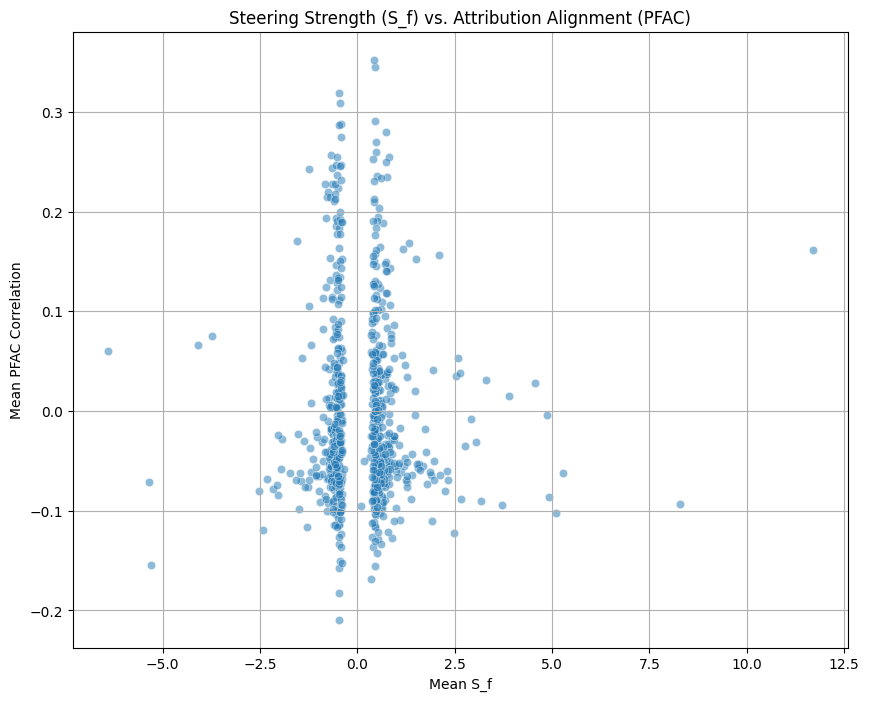


--- Top 20 Features by Attribution Alignment (PFAC) ---
     feature_id  mean_pfac_corr  mean_s_f  mean_gini_score  occurrences
683        4715        0.352373  0.421260         0.866537            3
682        2856        0.345100  0.466671         0.897162           15
707        1920        0.319075 -0.458600         0.882605            6
640        2018        0.309116 -0.452910         0.867026           12
724         472        0.290736  0.451881         0.912427            3
297          90        0.287437 -0.429237         0.792981           14
300         409        0.286585 -0.479849         0.802746           95
438        1872        0.279547  0.744735         0.904337          234
615         576        0.274673 -0.423381         0.826555           14
306        2142        0.269585  0.469888         0.856277           47
632        3787        0.259867  0.477204         0.832511           12
271        2733        0.256942 -0.682205         0.848686          475
324    

In [8]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the new comprehensive dictionary
comp_dict = stealth_dict

# Convert to DataFrame
df_list = []
for feat_id, stats in comp_dict['feature_stats'].items():
    row = {'feature_id': feat_id}
    row.update({k: v for k, v in stats.items() if k != 'raw_metrics'})
    df_list.append(row)
df = pd.DataFrame(df_list)

# --- Key Analysis: Does S_f correlate with PFAC? ---
print("Correlation between mean S_f and mean PFAC:")
print(df[['mean_s_f', 'mean_pfac_corr']].corr())

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='mean_s_f', y='mean_pfac_corr', alpha=0.5)
plt.title('Steering Strength (S_f) vs. Attribution Alignment (PFAC)')
plt.xlabel('Mean S_f')
plt.ylabel('Mean PFAC Correlation')
plt.grid(True)
plt.show()

# --- Let's look at the top-aligning features again ---
print("\n--- Top 20 Features by Attribution Alignment (PFAC) ---")
top_aligning = df.sort_values(by='mean_pfac_corr', ascending=False).head(20)
print(top_aligning[['feature_id', 'mean_pfac_corr', 'mean_s_f', 'mean_gini_score', 'occurrences']])

In [15]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import logging

logging.disable(logging.CRITICAL)


comp_dict = stealth_dict

# --- Convert to DataFrame for analysis ---
feature_stats = comp_dict.get('feature_stats', {})
if not feature_stats:
    print("No feature statistics found in the dictionary.")
    exit()

df_list = []
for feat_id, stats in feature_stats.items():
    row = {'feature_id': feat_id}
    row.update({k: v for k, v in stats.items() if k != 'raw_metrics'})
    df_list.append(row)
df = pd.DataFrame(df_list)

# --- Key Analysis: Does ABSOLUTE S_f correlate with PFAC? ---
# Create a new column for the absolute steering strength
df['abs_mean_s_f'] = df['mean_s_f'].abs()

print("\n" + "="*80)
print("Correlation between Absolute Steering Strength and Attribution Alignment:")
# Calculate the correlation between the absolute S_f and PFAC
correlation_matrix = df[['abs_mean_s_f', 'mean_pfac_corr']].corr()
print(correlation_matrix)
print("="*80 + "\n")


# --- Visualize the relationship ---
plt.figure(figsize=(10, 8))
# Use the new 'abs_mean_s_f' column for the x-axis
sns.scatterplot(
    data=df, 
    x='abs_mean_s_f', 
    y='mean_pfac_corr', 
    alpha=0.6, 
    # Optional: Color points by Gini score to add another dimension
    hue='mean_gini_score', 
    palette='viridis' 
)
plt.title('Absolute Steering Strength |S_f| vs. Attribution Alignment (PFAC)', fontsize=16)
plt.xlabel('Mean Absolute Steering Strength |S_f|', fontsize=12)
plt.ylabel('Mean Attribution Alignment (PFAC)', fontsize=12)
plt.xscale('log') # S_f values often have a long tail, log scale helps visualize
plt.grid(True, which="both", ls="--")
plt.show()


# --- Let's re-examine the top-aligning features with this new perspective ---
print("\n--- Top 20 Features by Attribution Alignment (PFAC) ---")
# Sort by PFAC to find the best features for our goal
top_aligning = df.sort_values(by='mean_pfac_corr', ascending=False).head(20)

# Display the absolute S_f value for these top features
print(top_aligning[[
    'feature_id', 
    'mean_pfac_corr', 
    'abs_mean_s_f', # Show the absolute value
    'mean_s_f',     # Also show the original to see if they are constructive/destructive
    'mean_gini_score', 
    'occurrences'
]])

# --- And let's look at the top-steering features ---
print("\n--- Top 20 Features by Absolute Steering Strength |S_f| ---")
# Sort by |S_f| to see if they are the same as the top-aligning ones
top_steering = df.sort_values(by='abs_mean_s_f', ascending=False).head(20)
print(top_steering[[
    'feature_id', 
    'abs_mean_s_f', 
    'mean_pfac_corr', # How well do the strongest steerers align?
    'mean_gini_score', 
    'occurrences'
]])

KeyError: 'mean_s_f'


Distribution of Mean Gini Scores:
count    731.000000
mean       0.764129
std        0.121240
min        0.186670
25%        0.710076
50%        0.792981
75%        0.848363
max        0.954198
Name: mean_gini_score, dtype: float64



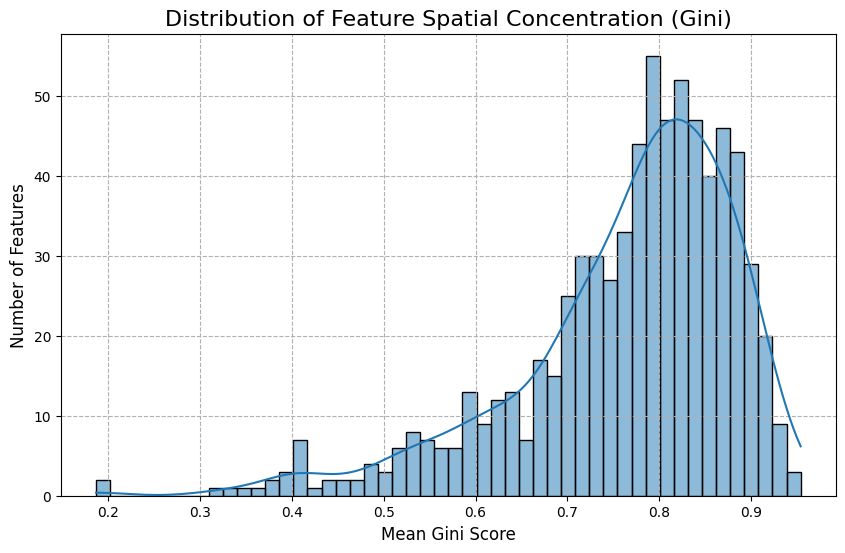


Correlation between Spatial Concentration (Gini) and Attribution Alignment (PFAC):
                 mean_gini_score  mean_pfac_corr
mean_gini_score         1.000000        0.222472
mean_pfac_corr          0.222472        1.000000



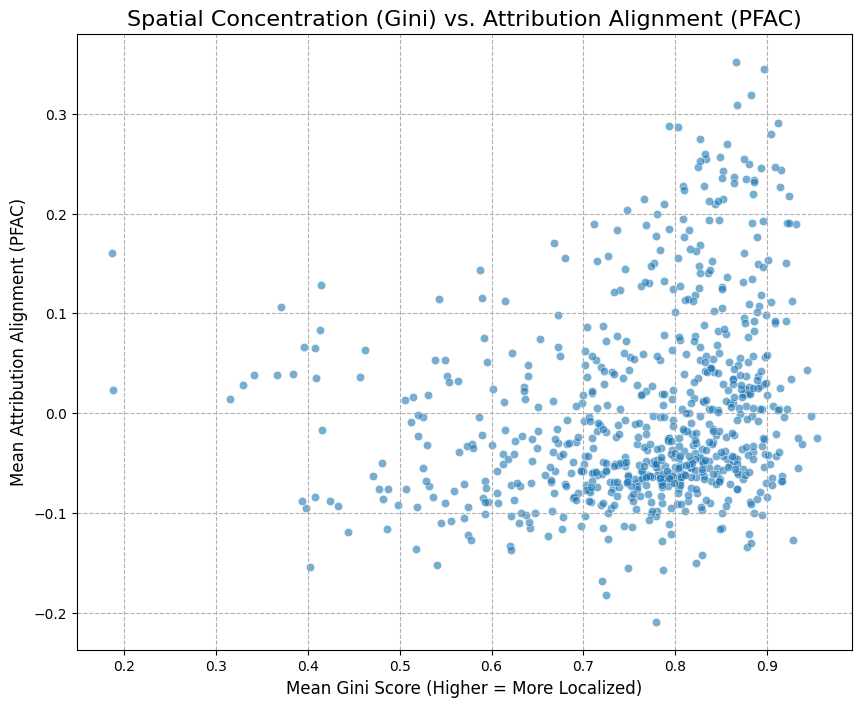


--- Top 20 Features by Attribution Alignment (PFAC) ---
Note the Gini scores for our best-aligning features:
     feature_id  mean_pfac_corr  mean_gini_score  occurrences
683        4715        0.352373         0.866537            3
682        2856        0.345100         0.897162           15
707        1920        0.319075         0.882605            6
640        2018        0.309116         0.867026           12
724         472        0.290736         0.912427            3
297          90        0.287437         0.792981           14
300         409        0.286585         0.802746           95
438        1872        0.279547         0.904337          234
615         576        0.274673         0.826555           14
306        2142        0.269585         0.856277           47
632        3787        0.259867         0.832511           12
271        2733        0.256942         0.848686          475
324        4522        0.255135         0.874900          154
266        2090       

In [11]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# --- Convert to DataFrame for analysis ---
feature_stats = comp_dict.get('feature_stats', {})
if not feature_stats:
    print("No feature statistics found in the dictionary.")
    exit()

df_list = []
for feat_id, stats in feature_stats.items():
    row = {'feature_id': feat_id}
    row.update({k: v for k, v in stats.items() if k != 'raw_metrics'})
    df_list.append(row)
df = pd.DataFrame(df_list)

# --- 1. How is Gini spread across all features? (Your first question) ---
print("\n" + "="*80)
print("Distribution of Mean Gini Scores:")
print(df['mean_gini_score'].describe())
print("="*80 + "\n")

plt.figure(figsize=(10, 6))
sns.histplot(df['mean_gini_score'], bins=50, kde=True)
plt.title('Distribution of Feature Spatial Concentration (Gini)', fontsize=16)
plt.xlabel('Mean Gini Score', fontsize=12)
plt.ylabel('Number of Features', fontsize=12)
plt.grid(True, which="both", ls="--")
plt.show()


# --- 2. Key Analysis: Does Gini correlate with PFAC? ---
print("\n" + "="*80)
print("Correlation between Spatial Concentration (Gini) and Attribution Alignment (PFAC):")
correlation_matrix = df[['mean_gini_score', 'mean_pfac_corr']].corr()
print(correlation_matrix)
print("="*80 + "\n")

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df, 
    x='mean_gini_score', 
    y='mean_pfac_corr', 
    alpha=0.6
)
plt.title('Spatial Concentration (Gini) vs. Attribution Alignment (PFAC)', fontsize=16)
plt.xlabel('Mean Gini Score (Higher = More Localized)', fontsize=12)
plt.ylabel('Mean Attribution Alignment (PFAC)', fontsize=12)
plt.grid(True, which="both", ls="--")
plt.show()


# --- 3. Compare the Top Feature Lists ---
print("\n--- Top 20 Features by Attribution Alignment (PFAC) ---")
top_aligning = df.sort_values(by='mean_pfac_corr', ascending=False).head(20)
print("Note the Gini scores for our best-aligning features:")
print(top_aligning[['feature_id', 'mean_pfac_corr', 'mean_gini_score', 'occurrences']])


print("\n--- Top 20 Features by Spatial Concentration (Gini) ---")
top_gini = df.sort_values(by='mean_gini_score', ascending=False).head(20)
print("Note the PFAC scores for the most-localized features:")
print(top_gini[['feature_id', 'mean_gini_score', 'mean_pfac_corr', 'occurrences']])